In [16]:
import numpy as np
import pandas as pd
import glob
from model.ctabgan import CTAB_XTRA_DP
df = pd.read_csv("Real_Datasets/adult.csv")
#df = df.drop(columns=['Year','Model'])

df = df.head(1000)
#df.loc[:7, 'capital-gain'] = np.nan
df.head(20)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,4,0,3,4,0,0,0,30,39,0
5,34,4,198693,0,4,8,1,4,1,0,0,30,39,0
6,29,0,227026,11,4,0,4,2,1,0,0,40,39,0
7,63,6,104626,14,2,10,0,4,1,3103,0,32,39,1
8,24,4,369667,15,4,8,4,4,0,0,0,40,39,0
9,55,4,104996,5,2,3,0,4,1,0,0,10,39,0


In [17]:

synthesizer =  CTAB_XTRA_DP(df,
                 categorical_columns = ["workclass","education","maritial-status","occupation","relationship","race","gender","native-country","income"], 
                 log_columns = {}, # Fuck this log, task for tommorrow
                 mixed_columns= {"capital-gain": [0]},
                 gaussian_columns = [],
                 integer_columns = [],
                 dp_constraints = {
                    "epsilon_budget": None,
                    "clip_coeff": None
                 }
                 ) 

In [18]:
synthesizer.fit(50)

Start training with 50 epochs
 5 critic iterations
 2 steps per epoch
 batch size 500


100%|██████████| 50/50 [06:33<00:00,  7.87s/it]


In [19]:
syn = synthesizer.generate_samples(1000)
syn.head(50)

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,51,6,59423,8,4,3,4,4,1,0,1805,41,39,0
1,56,7,89278,11,4,8,1,2,0,0,1805,24,19,0
2,37,4,235305,1,4,1,0,2,0,0,1805,65,36,0
3,55,6,54385,11,4,0,3,4,1,0,1806,40,19,1
4,58,4,210416,1,4,3,0,4,1,5621,1805,48,2,0
5,37,4,110257,8,3,4,1,4,1,6683,1805,35,40,1
6,55,4,160220,11,4,8,1,4,0,0,1805,48,19,0
7,23,4,154493,11,4,4,1,4,0,84326,1805,48,30,1
8,55,4,200663,8,2,8,0,4,0,0,1805,48,29,0
9,23,6,179472,11,2,10,3,4,1,0,1805,48,29,1


In [5]:
syn.shape

(1000, 14)

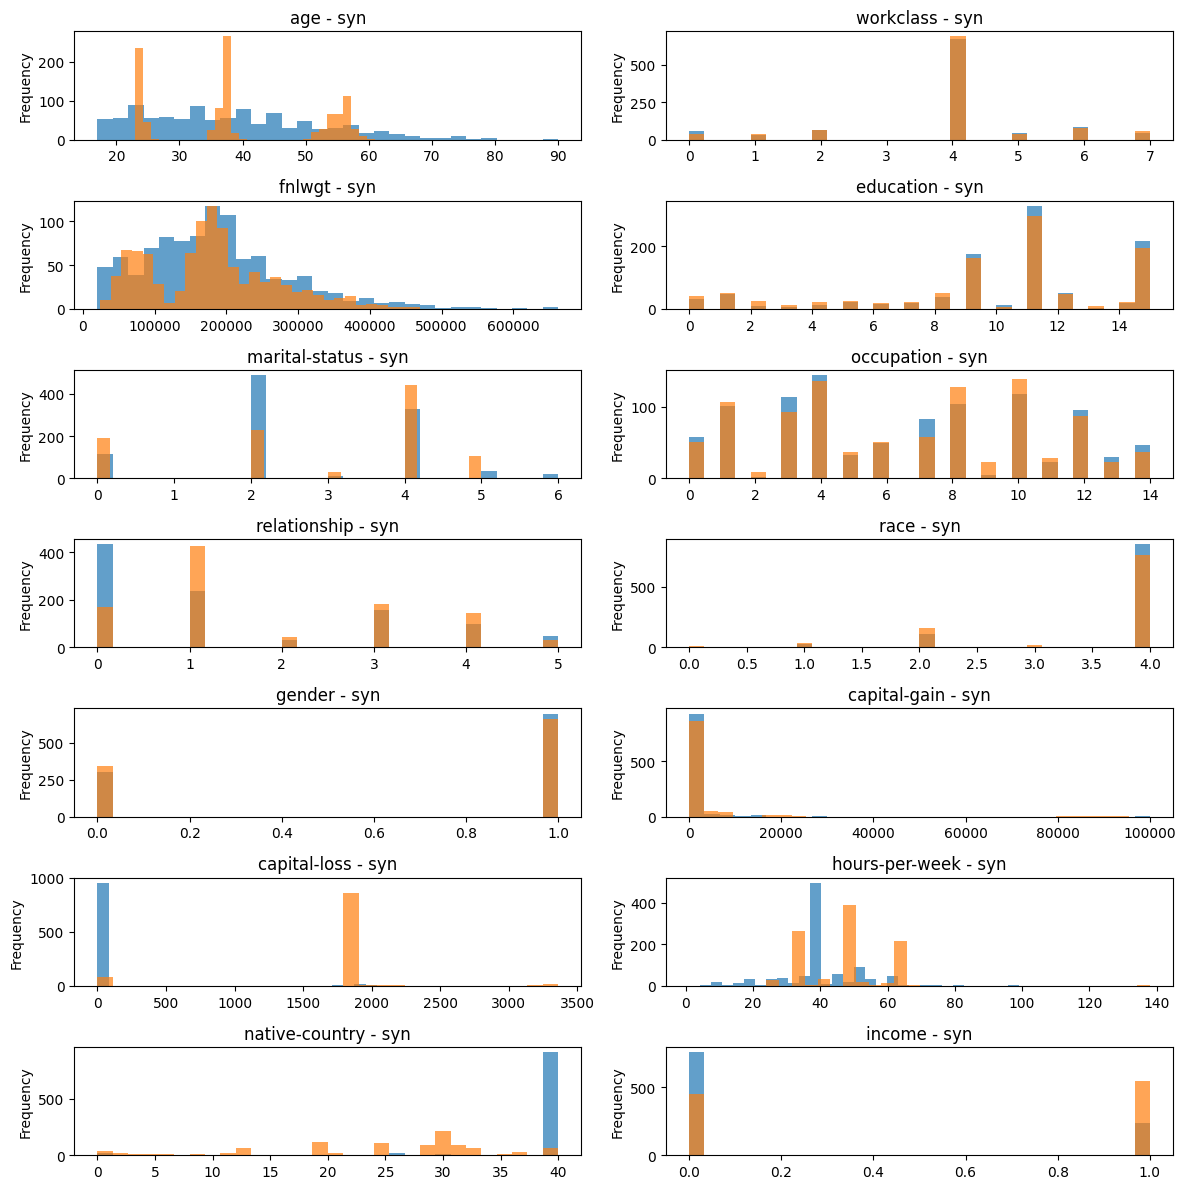

In [20]:
import matplotlib.pyplot as plt

# Create subplots dynamically based on the number of columns
num_cols = len(df.columns)
num_rows = (num_cols + 1) // 2  # Ensure enough rows for the number of columns

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(12, 12))

# Flatten axes into a 1D array for easier indexing
axes = axes.ravel()

for i, column in enumerate(df.columns):
    df[column].plot(kind='hist', ax=axes[i], title=f'{column} - df', bins=30, alpha=0.7)
    syn[column].plot(kind='hist', ax=axes[i], title=f'{column} - syn', bins=30, alpha=0.7)

plt.tight_layout()
plt.show()



In [7]:

from model.eval.evaluation import stat_sim

stat_sim(df,syn, ["workclass"])


column:  age WD:  0.05201369863013699
column:  workclass JSD:  0.047171014335513295
column:  fnlwgt WD:  0.04379177048424672
column:  education WD:  0.022200000000000004
column:  marital-status WD:  0.14016666666666663
column:  occupation WD:  0.043571428571428567
column:  relationship WD:  0.182
column:  race WD:  0.026000000000000002
column:  gender WD:  0.07500000000000001
column:  capital-gain WD:  0.008387573875738763
column:  capital-loss WD:  0.656879705400982
column:  hours-per-week WD:  0.0858061224489796
column:  native-country WD:  0.41405000000000003
column:  income WD:  0.305


[np.float64(0.1580666896983215),
 np.float64(0.047171014335513295),
 np.float64(2.0153806340365494)]

In [8]:
from model.eval.evaluation import privacy_metrics
privacy_metrics(df,syn)

==== Privacy Metrics Analysis ====
Using 15% of data for analysis
Real data sample size: 150
Fake data sample size: 150

Calculating pairwise distances...

== Nearest Neighbor Ratio Metrics (5th percentile) ==
Real-to-Real NN Ratio (5th): 0.5325
Fake-to-Fake NN Ratio (5th): 0.6681
Real-to-Fake NN Ratio (5th): 0.7397

== Minimum Distance Metrics (5th percentile) ==
Real-to-Fake Min Distance (5th): 1.6608
Real-to-Real Min Distance (5th): 1.0335
Fake-to-Fake Min Distance (5th): 1.5363

Privacy Risk Score: 1.2926
(Higher score indicates better privacy protection)

==== Summary Interpretation ====
✓ Good distance between real and synthetic records
✓ Good neighbor distance ratios


{'nn_ratio_rr_5th': np.float64(0.5324853411993341),
 'nn_ratio_ff_5th': np.float64(0.668079735441592),
 'nn_ratio_rf_5th': np.float64(0.7397012226129197),
 'min_dist_rf_5th': np.float64(1.6608084813306812),
 'min_dist_rr_5th': np.float64(1.03353509886446),
 'min_dist_ff_5th': np.float64(1.53626612019184),
 'privacy_risk_score': np.float64(1.2925579371781717),
 'metrics_array': array([[1.66080848, 1.0335351 , 1.53626612, 0.73970122, 0.53248534,
         0.66807974]])}